In [1]:
import pandas as pd
import sys

sys.path.append("../")

# ignore SettingWithCopyWarning
pd.options.mode.chained_assignment = None


In [2]:
from datetime import datetime

df = pd.read_csv("../data/casestudy_data.csv")
df["date_time"] = df["date_time"].apply(
    lambda x: datetime.strptime(x, "%m/%d/%y %H:%M")
)
cols_all = df.columns
df.head(3)


,visit_id,date_time,experience,success,zipcode,pro,repeat_visit,days_since_last_visit,new_movers,year_home_built,home_market_value,length_of_residence,net_worth,income,mkt_organic_product_purchasers_value,mkt_trend_env_focused_hh_value,high_end_shoppers_value,do_it_yourselfer_value,montrd_home_security_sys_own_value,mkt_green_product_purchasers_value
0,14167,2019-05-31 10:36:00,version1,0,30080,0,0,NaN,0,1987.0,320.0,8.0,250000.0,100000.0,29.0,25.0,25.0,55.0,28.0,39.0
1,195581,2019-05-31 10:37:00,version1,0,32081,1,0,NaN,0,2006.0,366.0,4.0,250000.0,125000.0,40.0,28.0,23.0,60.0,18.0,46.0
2,451142,2019-05-31 10:37:00,version2,0,91124,0,0,NaN,0,1988.0,504.0,13.0,500000.0,125000.0,21.0,12.0,16.0,76.0,32.0,31.0


In [3]:
df.columns


Index(['visit_id', 'date_time', 'experience', 'success', 'zipcode', 'pro',
       'repeat_visit', 'days_since_last_visit', 'new_movers',
       'year_home_built', 'home_market_value', 'length_of_residence',
       'net_worth', 'income', 'mkt_organic_product_purchasers_value',
       'mkt_trend_env_focused_hh_value', 'high_end_shoppers_value',
       'do_it_yourselfer_value', 'montrd_home_security_sys_own_value',
       'mkt_green_product_purchasers_value'],
      dtype='object')

In [4]:
df["version1_took"] = df.experience.apply(func=lambda x: int(x == "version1"))
df["version2_took"] = df.experience.apply(func=lambda x: int(x == "version2"))

df["version1_succeed"] = df.apply(
    func=(lambda row: int(row.experience == "version1" and row.success == 1)), axis=1
)
df["version2_succeed"] = df.apply(
    func=(lambda row: int(row.experience == "version2" and row.success == 1)), axis=1
)
df["date"] = df["date_time"].dt.floor("d")


<AxesSubplot: xlabel='date_time'>

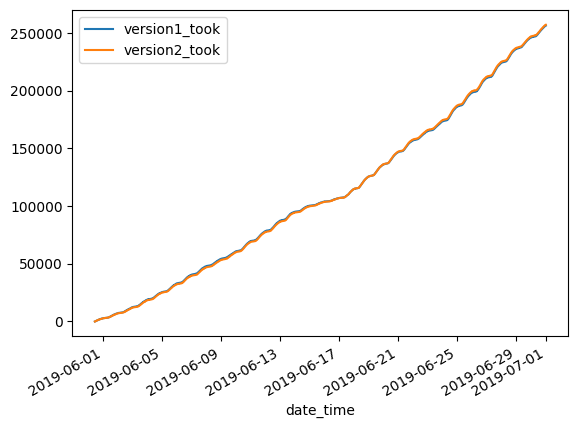

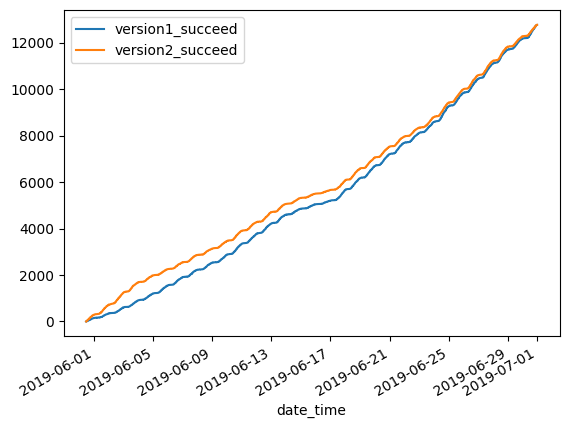

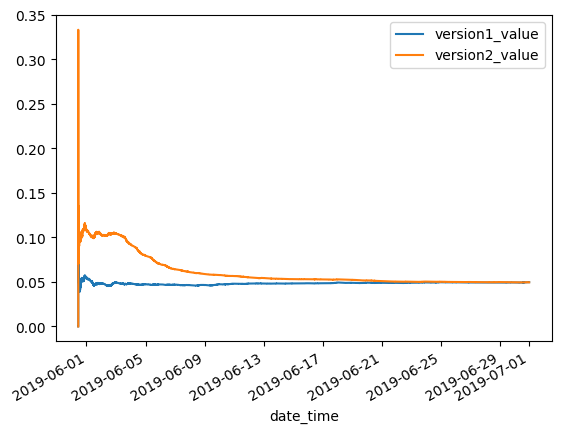

In [6]:
df_mab = df[
    [
        "date_time",
        "version1_took",
        "version2_took",
        "version1_succeed",
        "version2_succeed",
    ]
].copy()

df_mab = df_mab.set_index("date_time").sort_index()
df_mab = df_mab.cumsum()
df_mab["version1_value"] = df_mab["version1_succeed"] / df_mab["version1_took"]
df_mab["version2_value"] = df_mab["version2_succeed"] / df_mab["version2_took"]
df_mab[["version1_took", "version2_took"]].plot()
df_mab[["version1_succeed", "version2_succeed"]].plot()
df_mab[["version1_value", "version2_value"]].plot()


<AxesSubplot: xlabel='date'>

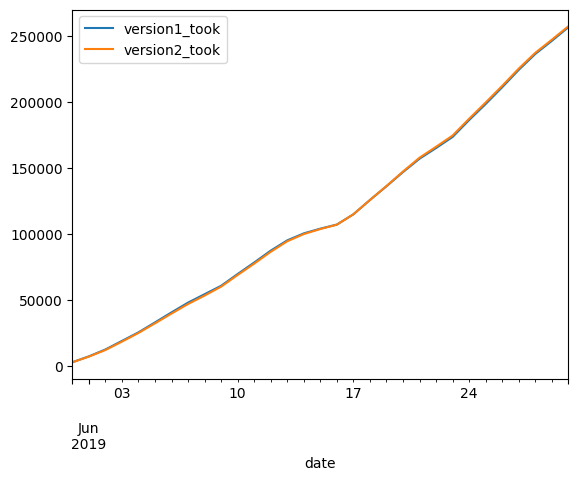

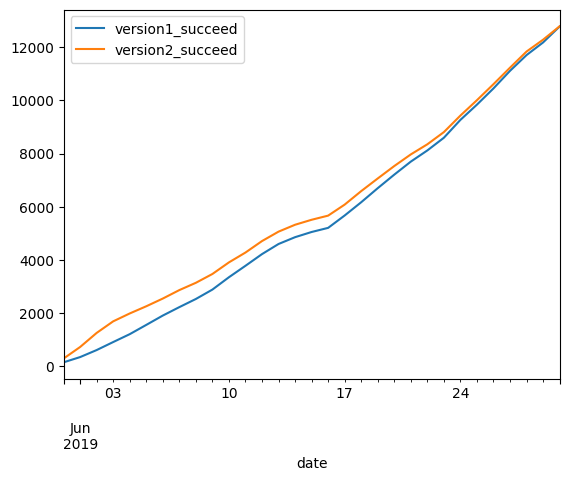

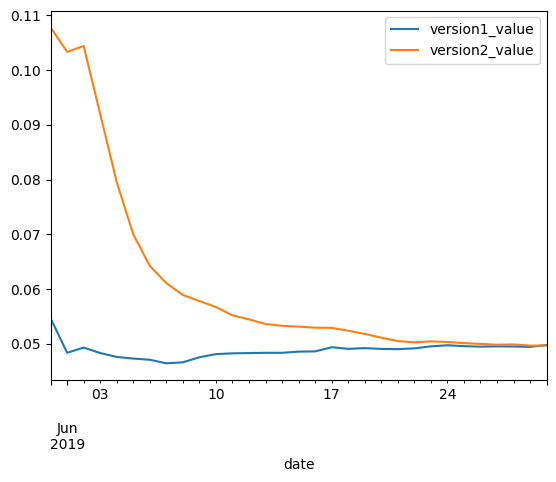

In [7]:
df_mab_daily = df[
    [
        "date",
        "version1_took",
        "version2_took",
        "version1_succeed",
        "version2_succeed",
    ]
].copy()

df_mab_daily = df_mab_daily.groupby("date", as_index=True).agg("sum")
df_mab_daily = df_mab_daily.sort_index().cumsum()
df_mab_daily["version1_value"] = (
    df_mab_daily["version1_succeed"] / df_mab_daily["version1_took"]
)
df_mab_daily["version2_value"] = (
    df_mab_daily["version2_succeed"] / df_mab_daily["version2_took"]
)

df_mab_daily[["version1_took", "version2_took"]].plot()
df_mab_daily[["version1_succeed", "version2_succeed"]].plot()
df_mab_daily[["version1_value", "version2_value"]].plot()


<AxesSubplot: xlabel='date'>

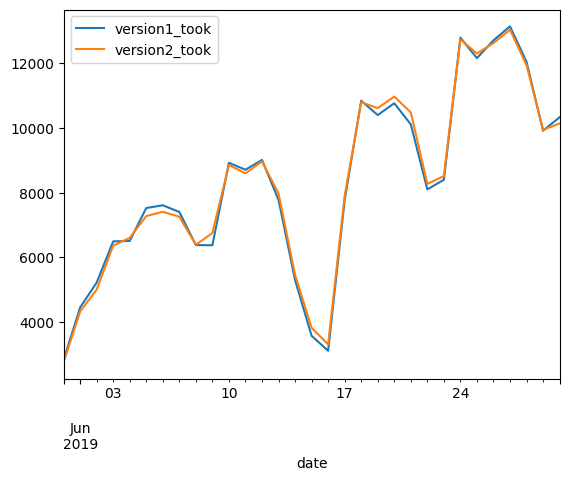

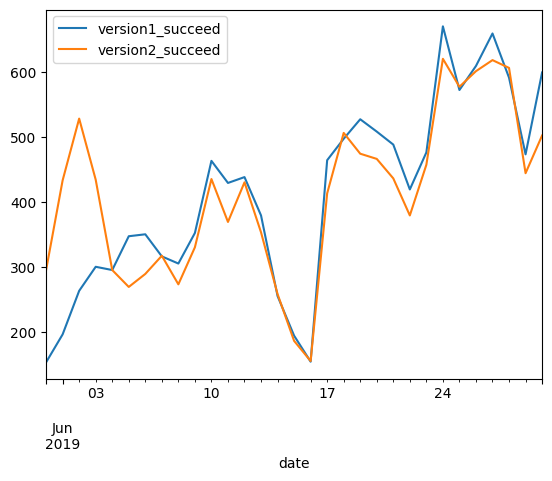

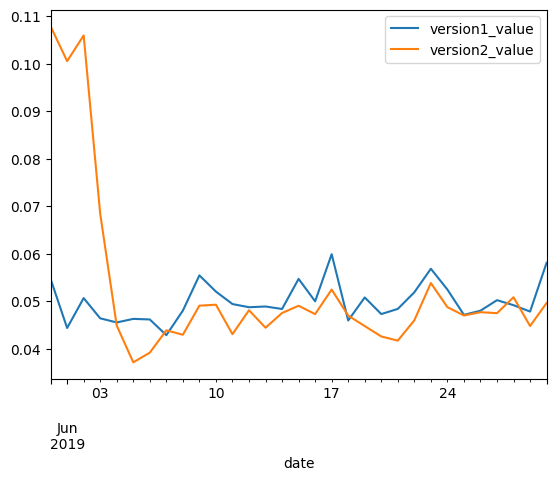

In [8]:
df_mab_daily = df[
    [
        "date",
        "version1_took",
        "version2_took",
        "version1_succeed",
        "version2_succeed",
    ]
].copy()

df_mab_daily = df_mab_daily.groupby("date", as_index=True).agg("sum")
df_mab_daily = df_mab_daily.sort_index()  # .cumsum()
df_mab_daily["version1_value"] = (
    df_mab_daily["version1_succeed"] / df_mab_daily["version1_took"]
)
df_mab_daily["version2_value"] = (
    df_mab_daily["version2_succeed"] / df_mab_daily["version2_took"]
)

df_mab_daily[["version1_took", "version2_took"]].plot()
df_mab_daily[["version1_succeed", "version2_succeed"]].plot()
df_mab_daily[["version1_value", "version2_value"]].plot()


# Evaluate baseline strategies: always recommending version1 or version2

In [5]:
def evaluate_recommendation(df: "pd.DataFrame") -> int:
    return sum((df.experience == df.recommendation) & (df.success == 1))


df_result = df[["date", "experience", "success"]].copy()
df_result["recommendation"] = "version1"
print(
    "success count when always recommending version1: ",
    evaluate_recommendation(df_result),
)
df_result["recommendation"] = "version2"
print(
    "success count when always recommending version2: ",
    evaluate_recommendation(df_result),
)


success count when always recommending version1:  12772
success count when always recommending version2:  12779


# Evaluate strategy: recommendation by last n days' performance

In [10]:
import math

df_daily = (
    df[
        [
            "date",
            "version1_took",
            "version2_took",
            "version1_succeed",
            "version2_succeed",
        ]
    ]
    .groupby("date", as_index=True)
    .agg("sum")
)
df_daily["version1_value"] = df_daily["version1_succeed"] / df_daily["version1_took"]
df_daily["version2_value"] = df_daily["version2_succeed"] / df_daily["version2_took"]


df_daily["version1_value_yesterday"] = df_daily["version1_value"].shift(1)
df_daily["version2_value_yesterday"] = df_daily["version2_value"].shift(1)
df_daily["version1_prob_yesterday"] = df_daily.apply(
    axis=1,
    # func=lambda row: row["version1_value_yesterday"]
    # / (row["version1_value_yesterday"] + row["version2_value_yesterday"]),
    func=lambda row: math.exp(row["version1_value_yesterday"])
    / (
        math.exp(row["version1_value_yesterday"])
        + math.exp(row["version2_value_yesterday"])
    ),
)
df_daily["version1_prob_yesterday"] = df_daily["version1_prob_yesterday"].fillna(0.5)


df_daily.head(3)


,version1_took,version2_took,version1_succeed,version2_succeed,version1_value,version2_value,version1_value_yesterday,version2_value_yesterday,version1_prob_yesterday
date,,,,,,,,,
2019-05-31,2817,2745,154,296,0.054668,0.107832,NaN,NaN,0.500000
2019-06-01,4442,4318,197,434,0.044349,0.100509,0.054668,0.107832,0.486712
2019-06-02,5213,4995,264,529,0.050643,0.105906,0.044349,0.100509,0.485964


13436 epsilon=0
mean: 13404.44, std: 42.21547583529055, epsilon=0.05


{'whiskers': [<matplotlib.lines.Line2D at 0x7fdbe26584f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdbe2658a30>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdbe2658250>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdbe2658f70>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdbe2659210>],
 'means': []}

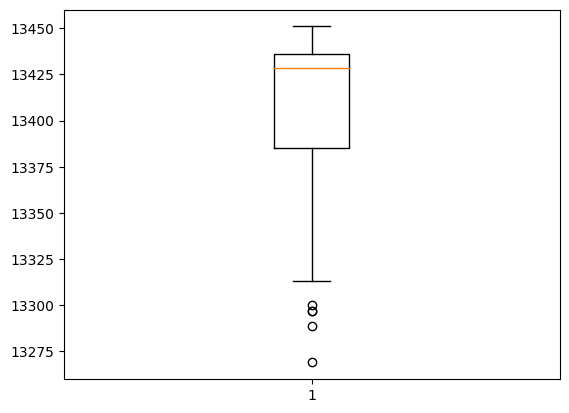

In [11]:
# recommendation by yesterday's performance, using epsilon to balance
# exploration / exploitation
import random
from matplotlib import pyplot as plt
import numpy as np


def recommend_by_yesterday_performance(
    df_daily: "pd.DataFrame", epsilon: float = 0
) -> "pd.DataFrame":
    assert 0 <= epsilon <= 1

    df_daily["recommendation"] = df_daily.apply(
        axis=1,
        func=lambda row: "version1"
        if (row["version1_value_yesterday"] > row["version2_value_yesterday"])
        and random.random() < (1 - epsilon)
        else "version2",
    )
    return df_daily


df_daily = recommend_by_yesterday_performance(df_daily, epsilon=0)
df_result = df[["date", "experience", "success"]].merge(
    df_daily[["recommendation"]], on="date", how="inner"
)

print(evaluate_recommendation(df_result), "epsilon=0")

success_counts = []
for _ in range(100):
    df_daily = recommend_by_yesterday_performance(df_daily, epsilon=0.05)

    df_result = df[["date", "experience", "success"]].merge(
        df_daily[["recommendation"]], on="date", how="inner"
    )

    success_counts.append(evaluate_recommendation(df_result))

print(f"mean: {np.mean(success_counts)}, std: {np.std(success_counts)}, epsilon=0.05")
plt.boxplot(x=success_counts)


mean: 12774.16, std: 213.55302479712154


{'whiskers': [<matplotlib.lines.Line2D at 0x7fdbe24ba860>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdbe24bac80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdbe24ba5c0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdbe24bb1c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdbe24bb460>],
 'means': []}

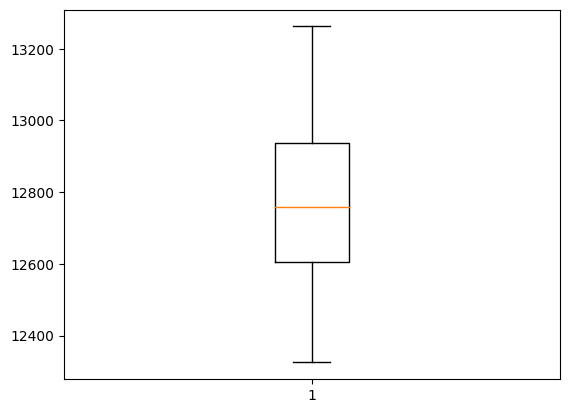

In [12]:
# recommendation by yesterday's performance, using probability to balance
# exploration / exploitation

import random
from matplotlib import pyplot as plt


def recommend_by_yesterday_performance_prob(df_daily: "pd.DataFrame") -> "pd.DataFrame":

    df_daily["recommendation"] = df_daily.apply(
        axis=1,
        func=lambda row: "version1"
        if random.random() < row["version1_prob_yesterday"]
        else "version2",
    )
    return df_daily


success_counts = []
for _ in range(100):
    df_daily = recommend_by_yesterday_performance_prob(df_daily)

    df_result = df[["date", "experience", "success"]].merge(
        df_daily[["recommendation"]], on="date", how="inner"
    )

    success_counts.append(evaluate_recommendation(df_result))

print(f"mean: {np.mean(success_counts)}, std: {np.std(success_counts)}")
plt.boxplot(x=success_counts)


In [51]:
import numpy as np

index_helper = {c: {} for c in df.columns}

for c in df.columns:
    for i, v in enumerate(df[c].unique()):
        index_helper[c][str(v)] = i


In [9]:
cols_other = ["visit_id", "zipcode", "date", "date_time", "success", "experience"]

cols_input = list(set(cols_all) - set(cols_other))

for c in cols_input:
    print(df[c].nunique(), c)


2 pro
99 mkt_organic_product_purchasers_value
99 mkt_trend_env_focused_hh_value
98 montrd_home_security_sys_own_value
13 income
2 repeat_visit
98 do_it_yourselfer_value
6 days_since_last_visit
99 high_end_shoppers_value
109 year_home_built
886 home_market_value
10 net_worth
8 length_of_residence
2 new_movers
99 mkt_green_product_purchasers_value


In [21]:
cols_other = ["visit_id", "zipcode", "date", "date_time", "success", "experience"]
# cols_input = ["income", "year_home_built", "days_since_last_visit"]
cols_input = ["length_of_residence", "new_movers"]
# cols_input = list(set(cols_all) - set(cols_other))

df_input = df[cols_other].copy()

for c in cols_input:
    df_feature = pd.get_dummies(df[[c]].copy().fillna(value=0))
    df_input = pd.concat([df_input, df_feature], axis=1)

cols_input_feature = list(set(df_input.columns) - set(cols_other))
print(cols_input_feature)
df_input


['length_of_residence', 'new_movers']


,visit_id,zipcode,date,date_time,success,experience,length_of_residence,new_movers
0,14167,30080,2019-05-31,2019-05-31 10:36:00,0,version1,8.0,0
1,195581,32081,2019-05-31,2019-05-31 10:37:00,0,version1,4.0,0
2,451142,91124,2019-05-31,2019-05-31 10:37:00,0,version2,13.0,0
3,278496,60614,2019-05-31,2019-05-31 10:37:00,0,version1,8.0,0
4,316757,76309,2019-05-31,2019-05-31 10:37:00,0,version2,8.0,0
...,...,...,...,...,...,...,...,...
513858,382921,98362,2019-06-30,2019-06-30 23:59:00,0,version2,13.0,0
513859,186356,72712,2019-06-30,2019-06-30 23:59:00,0,version1,8.0,0
513860,355431,63146,2019-06-30,2019-06-30 23:59:00,0,version1,13.0,1
513861,480424,70526,2019-06-30,2019-06-30 23:59:00,0,version1,18.0,1


In [73]:
from typing import List
from datetime import timedelta
import random


random.seed(0)  # fix the random seed for reproducibility


def generate_remommendation(
    model: "sklearn model", df_input: "pd.DataFrame", cols_input: List[str]
) -> "pd.DataFrame":

    results = []
    df_yesterday = None
    dates = sorted(set(df_input.date))
    for date in dates:
        df_today = df_input[(df_input.date == date) & (df_input.success == 1)]
        is_first_day = df_yesterday is None
        if is_first_day:
            # randomly select an action on the first day
            df_today["recommendation"] = random.choice(["version1", "version2"])
        else:
            # train a model using yesterday's data
            model = model.fit(
                df_yesterday[cols_input],
                df_yesterday.experience,
            )
            # use the model to make recommendations for today
            df_today["recommendation"] = model.predict(df_today[cols_input])

        results.append(df_today.copy())
        df_yesterday = df_today

    return pd.concat(results, axis=0)


import pandasql as ps


def plot_correct_rate() -> None:
    ps.sqldf(
        f"""
        SELECT
            date,
            1.0 * sum(experience = recommendation) / count(1) AS correct_rate
        FROM
            df_result
        WHERE
            success=1
        GROUP BY
            1;
        """
    ).plot.bar()


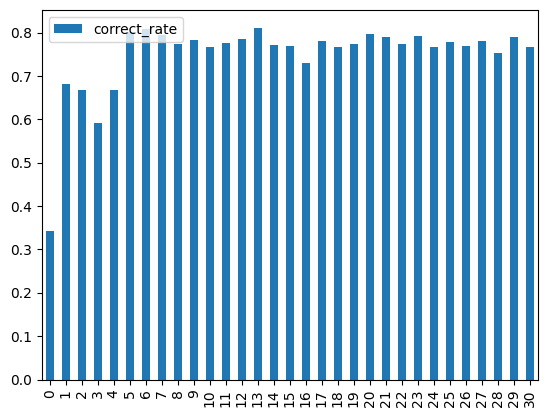

In [55]:
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf = tree.DecisionTreeClassifier(random_state=0)
# clf = make_pipeline(StandardScaler(), tree.DecisionTreeClassifier(random_state=0))

df_result = generate_remommendation(
    model=clf, df_input=df_input, cols_input=cols_input_feature
)
# 13436 epsilon=0
# 19496 for cols_input = ["length_of_residence", "new_movers"]
# 17355 for cols_input = list(set(cols_all) - set(cols_other))
print(evaluate_recommendation(df_result))  # 19496
plot_correct_rate()


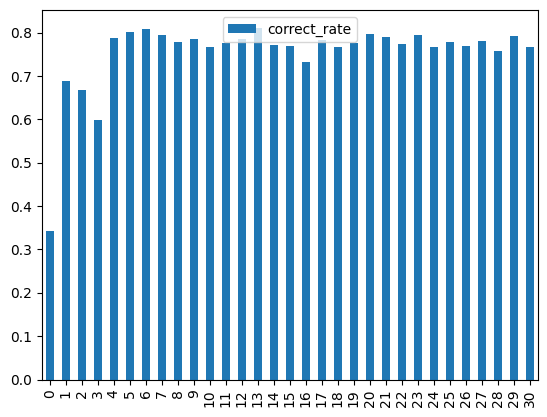

In [54]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# clf = linear_model.LogisticRegression(random_state=0)
clf = make_pipeline(StandardScaler(), linear_model.LogisticRegression(random_state=0))


df_result = generate_remommendation(
    model=clf, df_input=df_input, cols_input=cols_input_feature
)
# 13436 epsilon=0
# 19596 for cols_input = ["length_of_residence", "new_movers"]
# 19504 for cols_input = list(set(cols_all) - set(cols_other))
print(evaluate_recommendation(df_result))  # 19596
plot_correct_rate()


In [69]:
from typing import List
from datetime import timedelta
import random


random.seed(0)  # fix the random seed for reproducibility


def generate_remommendation_using_all_data(
    model: "sklearn model", df_input: "pd.DataFrame", cols_input: List[str]
) -> "pd.DataFrame":

    results = []
    df_yesterday = None
    dates = sorted(set(df_input.date))
    for date in dates:
        df_today = df_input[(df_input.date == date)]
        df_today.loc[df_input.success == 0, "experience"] = "unknown"
        is_first_day = df_yesterday is None
        if is_first_day:
            # randomly select an action on the first day
            df_today["recommendation"] = random.choice(["version1", "version2"])
        else:
            # train a model using yesterday's data
            model = model.fit(
                df_yesterday[cols_input],
                df_yesterday.experience,
            )
            # use the model to make recommendations for today
            df_today["recommendation"] = model.predict(df_today[cols_input])

        results.append(df_today.copy())
        df_yesterday = df_today

    return pd.concat(results, axis=0)

19134


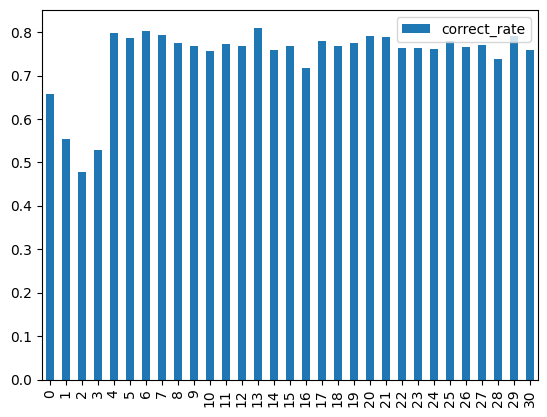

In [74]:
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf = tree.DecisionTreeClassifier(random_state=0, class_weight="balanced")
# clf = make_pipeline(StandardScaler(), tree.DecisionTreeClassifier(random_state=0))

df_result = generate_remommendation_using_all_data(
    model=clf, df_input=df_input, cols_input=cols_input_feature
)
# 13436 epsilon=0
# 19496 for cols_input = ["length_of_residence", "new_movers"]
# 17355 for cols_input = list(set(cols_all) - set(cols_other))
print(evaluate_recommendation(df_result))  # 19134
plot_correct_rate()
